# Version 2 Functions

Version 2 has been broken down into separate functions.

In [1]:
# Import all of the nessasary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to calculate the area in mm^2
def calculate_area(contour, scale):
    return cv2.contourArea(contour) * (scale ** 2)

In [3]:
# Function to calculate distance in mm
def calculate_length(points, scale):
    return cv2.arcLength(points, closed=False) * scale

In [4]:
# Load the image
def load_image(image_path):
    image_path = "Sample Data/Leaf-with-scars-1.png"
    image = cv2.imread(image_path)
    return image

In [5]:
#Create masks
def create_mask(hsv_image):
    # Define color ranges for calibration cube (purple), leaf (green), and scars (brown)
    purple_lower = np.array([120, 50, 50])
    purple_upper = np.array([160, 255, 255])

    green_lower = np.array([35, 40, 40])
    green_upper = np.array([85, 255, 255])

    brown_lower = np.array([10, 50, 50])
    brown_upper = np.array([20, 255, 200])

    # Create masks for the calibration cube, leaf, and scars
    purple_mask = cv2.inRange(hsv_image, purple_lower, purple_upper)
    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
    brown_mask = cv2.inRange(hsv_image, brown_lower, brown_upper)

    return purple_mask, green_mask, brown_mask

In [6]:
# Find contours of the calibration cube
def find_cube_contours(purple_mask):
    cube_contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cube_contour = max(cube_contours, key=cv2.contourArea)
    return cube_contour

In [7]:
# Find contours of the leaf
def find_leaf_contours(green_mask):
    leaf_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    leaf_contour = max(leaf_contours, key=cv2.contourArea)
    return leaf_contour

In [8]:
# Find contours of the scars
def find_scar_contours(brown_mask):
    scar_contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return scar_contours

In [9]:
# Get bounding box of the calibration cube and calculate the scale
def calculate_scale(cube_contour):
    x, y, w, h = cv2.boundingRect(cube_contour)
    scale = 500 / w  # Assuming the cube is 500mm x 500mm
    return scale

In [10]:
# Filter out scars that are not on the leaf
def find_valid_scars(scar_contours, leaf_contour):
    valid_scar_contours = []
    for contour in scar_contours:
        # Check if the center of the scar is inside the leaf contour
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            if cv2.pointPolygonTest(leaf_contour, (cx, cy), False) >= 0:
                valid_scar_contours.append(contour)

    return valid_scar_contours

In [11]:
# Calculate scar areas in mm^2 and count the valid scars
def calculate_scar_properties(valid_scar_contours, scale):
    scar_areas = [calculate_area(contour, scale) for contour in valid_scar_contours]
    scar_count = len(scar_areas)
    total_scar_area = sum(scar_areas)
    return scar_count, total_scar_area

In [12]:
def main(image_path):
    image = load_image(image_path)
    # Display the image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create masks for the calibration cube, leaf, and scars
    purple_mask, green_mask, brown_mask = create_mask(hsv_image)

    # Find contours of the calibration cube
    cube_contour = find_cube_contours(purple_mask)

    # Find contours of the leaf
    leaf_contour = find_leaf_contours(green_mask)

    # Find contours of the scars
    scar_contours = find_scar_contours(brown_mask)

    # Calculate scale
    scale = calculate_scale(cube_contour)

    # Calculate leaf area in mm^2
    leaf_area = calculate_area(leaf_contour, scale)

    # Filter out scars that are not on the leaf
    valid_scar_contours = find_valid_scars(scar_contours, leaf_contour)

    # Calculate scar areas in mm^2 and count the valid scars
    scar_count, total_scar_area = calculate_scar_properties(valid_scar_contours, scale)

    # Calculate percentage damage
    percentage_damage = (total_scar_area / leaf_area) * 100

    # Approximate the length of the petiole (assuming it's a straight line)
    petiole_length = calculate_length(leaf_contour, scale)

    # Print the results
    print(f"Image: {image_path}")
    print(f"Leaf Area: {leaf_area:.2f} mm^2")
    print(f"Total Scar Area: {total_scar_area:.2f} mm^2")
    print(f"Percentage Damage: {percentage_damage:.2f}%")
    print(f"Number of Scars: {scar_count}")
    print(f"Petiole Length: {petiole_length:.2f} mm")

    # Optionally display the results visually
    cv2.drawContours(image, [leaf_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(image, valid_scar_contours, -1, (0, 0, 255), 2)
    cv2.imshow("Leaf and Scars", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Display the original and annotated images
    plt.subplot(1, 2, 2)
    plt.title('Leaf with Scars')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

## Execute the functions

Image: Sample Data/Leaf-with-scars-1.png
Leaf Area: 5052479.03 mm^2
Total Scar Area: 216894.26 mm^2
Percentage Damage: 4.29%
Number of Scars: 8
Petiole Length: 12266.11 mm


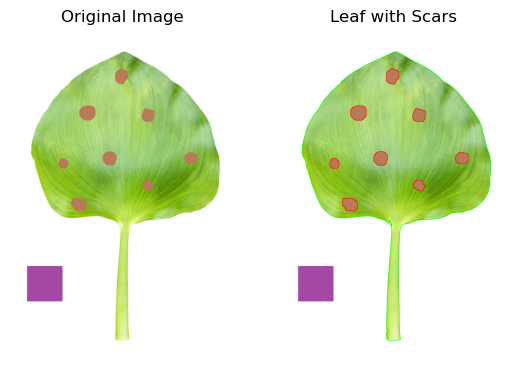

In [13]:
main("Sample Data/Leaf-with-scars-1.png")